# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "bi-ml-competition-2023"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [40]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [6]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 115 µs, sys: 82 µs, total: 197 µs
Wall time: 114 µs


#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [89]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

# X_test = df_test_features.values
# y_test_pred = rf_model.predict_proba(X_test)[:, 1]

# df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
#                                  index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-03-30_18-38-01.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [7]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [8]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 125 µs, sys: 495 µs, total: 620 µs
Wall time: 627 µs


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [19]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [20]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [21]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

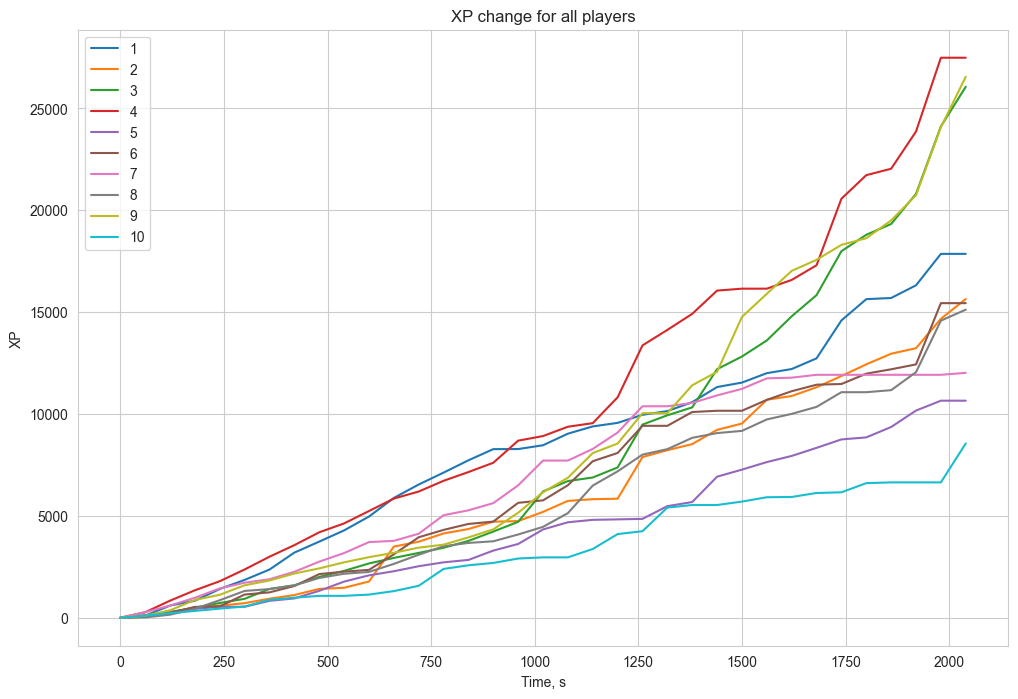

In [22]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [9]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

In [10]:
    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file, encoding='utf-8') as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [11]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [ ]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

In [91]:
df_test_features_extended = df_test_features.copy()


add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [27]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [28]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 149 ms, sys: 481 ms, total: 630 ms
Wall time: 2min 3s


In [29]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Приступим

### Признаки для 1 игрока из готового датасета:

In [13]:
df_train_features.columns[-20:-1]

Index(['d5_denies', 'd5_gold', 'd5_lh', 'd5_xp', 'd5_health', 'd5_max_health',
       'd5_max_mana', 'd5_level', 'd5_x', 'd5_y', 'd5_stuns',
       'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed'],
      dtype='object')

In [14]:
df_train_features.iloc[:, 5:29].info()

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   r1_hero_id                  31698 non-null  int64  
 1   r1_kills                    31698 non-null  int64  
 2   r1_deaths                   31698 non-null  int64  
 3   r1_assists                  31698 non-null  int64  
 4   r1_denies                   31698 non-null  int64  
 5   r1_gold                     31698 non-null  int64  
 6   r1_lh                       31698 non-null  int64  
 7   r1_xp                       31698 non-null  int64  
 8   r1_health                   31698 non-null  int64  
 9   r1_max_health               31698 non-null  int64  
 10  r1_max_mana                 31698 non-null  float64
 11  r1_level                    31698 non-null  int64  
 12  r1_x                        31698 n

In [15]:
df_train_features.iloc[:, 5:29].describe()

,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,...,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed
count,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,...,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000
mean,51.081614,3.151713,3.273361,4.661998,6.255600,7202.005079,65.033882,8300.697457,943.584012,1318.727428,...,11.770936,0.790681,0.265758,4.346331,0.091488,0.418969,0.339864,0.029339,1.204776,0.766547
std,34.573173,3.727116,3.281208,5.207887,8.144267,6514.917959,77.233353,7482.636072,681.995335,623.145054,...,20.454084,2.766434,0.771435,4.315433,0.288307,0.267317,0.774504,0.185331,2.493819,2.352856
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,300.000000,...,-6.724344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,1.000000,1.000000,1.000000,2208.250000,11.000000,2304.000000,527.000000,840.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.243243,0.000000,0.000000,0.000000,0.000000
50%,44.000000,2.000000,2.000000,3.000000,3.000000,5433.500000,37.000000,6014.000000,845.500000,1160.000000,...,1.499617,0.000000,0.000000,3.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000
75%,81.000000,5.000000,5.000000,7.000000,9.000000,10370.000000,92.000000,12392.000000,1301.000000,1640.000000,...,16.029322,0.000000,0.000000,6.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000
max,120.000000,32.000000,27.000000,40.000000,83.000000,58437.000000,846.000000,31004.000000,7780.000000,7780.000000,...,328.755220,69.000000,13.000000,45.000000,1.000000,2.000000,8.000000,3.000000,29.000000,48.000000


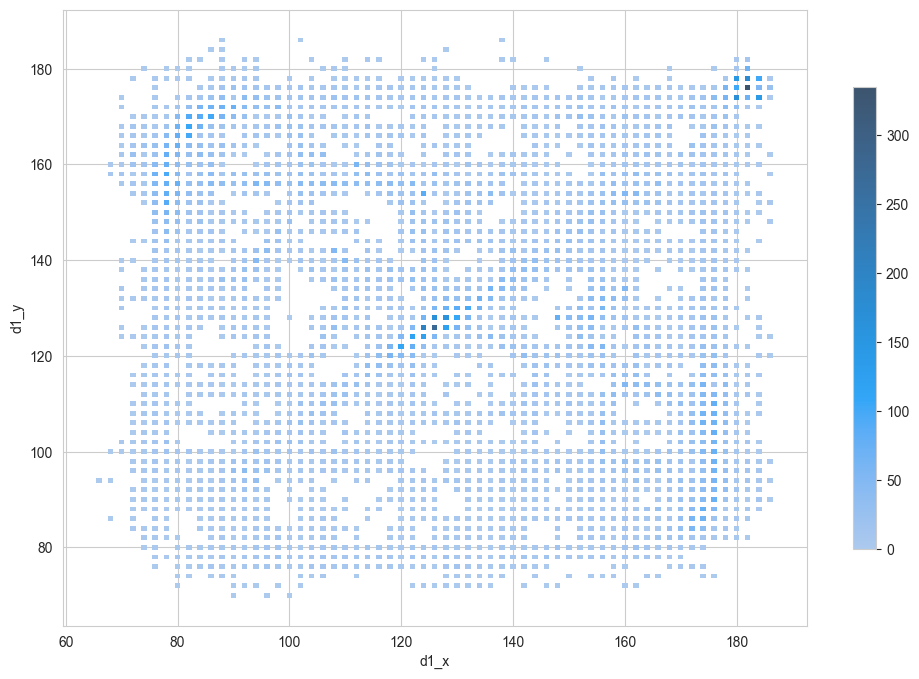

In [16]:
sns.histplot(df_train_features, x='d1_x', y='d1_y', discrete=(True, True), 
             cbar=True, cbar_kws=dict(shrink=.75));

Абсолютно рандомные признаки, связанные с координатами. Еще не понятно на какой момент игры сделаны 

In [17]:
df_new = df_train_features.drop(['r1_y','r2_y','r3_y','r4_y','r5_y',
                       'r1_x','r2_x','r3_x','r4_x','r5_x',
                       'd1_y','d2_y','d3_y','d4_y','d5_y',
                       'd1_x','d2_x','d3_x','d4_x','d5_y'], axis=1)

## Найдем процент побед каждого из героев в ту эпоху (мету)

In [35]:
import requests
from bs4 import BeautifulSoup

Кажется, героев меньше чем сейчас в доте. Какой это год...?

In [36]:
df_200 = read_matches('bi-ml-competition-2023/train_raw_data.jsonl', n_matches_to_read=200)

df_id = pd.DataFrame(columns=['id', 'Hero'])

In [37]:
c = 0
for game in df_200:
    for i in range(10):
        df_id.loc[c] = [game['players'][i]['hero_id'],
                            game['players'][i]['hero_name']]
        c += 1



  0%|          | 0/31698 [00:00<?, ?it/s]

In [38]:
df_id.loc[df_id.id > 118].Hero.unique()

array(['npc_dota_hero_dark_willow', 'npc_dota_hero_pangolier'],
      dtype=object)

**Это патч 7.07 конца 2017 года. Именно тогда добавили этих героев...**

### Посмотрим процент побед героев то время

In [39]:
response = requests.get('https://web.archive.org/web/20171227161324/https://www.dotabuff.com/heroes/winning')

In [40]:
soup = BeautifulSoup(response.content, 'lxml')

In [41]:
heroes = soup.find_all('tr')

In [42]:
hero_wr = pd.DataFrame(columns=['Hero', 'WR'])

for hero in range(1,116):    
    hero_wr.loc[hero] = [heroes[hero].find('td', class_='cell-xlarge').text,
                        heroes[hero].find_all('td')[2].attrs['data-value']]
    

In [43]:
hero_wr

,Hero,WR
1,Zeus,56.383
2,Spectre,55.5249
3,Vengeful Spirit,55.2188
4,Underlord,55.1138
5,Wraith King,55.0822
...,...,...
111,Broodmother,41.8562
112,Nature's Prophet,41.3607
113,Alchemist,40.9507
114,Io,37.7753


### Найдем id каждого из героев

In [44]:
df_id.Hero = list(map(lambda x: x.replace('npc_dota_hero_','').replace('_',' ').title(), df_id.Hero))
df_id.Hero

0               Razor
1             Centaur
2       Shadow Shaman
3              Weaver
4          Naga Siren
            ...      
1995          Slardar
1996           Furion
1997            Lycan
1998           Dazzle
1999             Riki
Name: Hero, Length: 2000, dtype: object

In [46]:
Names = pd.merge(df_id, hero_wr, on='Hero').Hero
Names
df_id.loc[-df_id.Hero.isin(Names)].Hero.unique()

array(['Centaur', 'Antimage', 'Rattletrap', 'Furion', 'Shredder',
       'Abyssal Underlord', 'Keeper Of The Light', 'Wisp',
       'Obsidian Destroyer', 'Nevermore', 'Skeleton King', 'Windrunner',
       'Doom Bringer', 'Queenofpain', 'Life Stealer', 'Necrolyte', 'Zuus',
       'Treant', 'Vengefulspirit', 'Magnataur'], dtype=object)

**Видно, что в json файлах некоторые герои называются _ПО-ДРУГОМУ_. Исправим это**

In [47]:
df_id.id = df_id.id.astype('int64')
id_old_df = df_id.drop_duplicates().sort_values(by='id')
id_old_df.loc[id_old_df.Hero == 'Rattletrap', 'Hero'] = 'Clockwerk'
id_old_df.loc[id_old_df.Hero == 'Vengefulspirit', 'Hero'] = 'Vengeful Spirit'
id_old_df.loc[id_old_df.Hero == 'Queenofpain', 'Hero'] = 'Queen of Pain'
id_old_df.loc[id_old_df.Hero == 'Treant', 'Hero'] = 'Treant Protector'
id_old_df.loc[id_old_df.Hero == 'Nevermore', 'Hero'] = 'Shadow Fiend'
id_old_df.loc[id_old_df.Hero == 'Obsidian Destroyer', 'Hero'] = 'Outworld Devourer'
id_old_df.loc[id_old_df.Hero == 'Necrolyte', 'Hero'] = 'Necrophos'
id_old_df.loc[id_old_df.Hero == 'Magnataur', 'Hero'] = 'Magnus'
id_old_df.loc[id_old_df.Hero == 'Skeleton King', 'Hero'] = 'Wraith King'
id_old_df.loc[id_old_df.Hero == 'Wisp', 'Hero'] = 'Io'
id_old_df.loc[id_old_df.Hero == 'Abyssal Underlord', 'Hero'] = 'Underlord'
id_old_df.loc[id_old_df.Hero == 'Shredder', 'Hero'] = 'Timbersaw'
id_old_df.loc[id_old_df.Hero == 'Doom Bringer', 'Hero'] = 'Doom'
id_old_df.loc[id_old_df.Hero == 'Zuus', 'Hero'] = 'Zeus'
id_old_df.loc[id_old_df.Hero == 'Antimage', 'Hero'] = 'Anti-Mage'
id_old_df.loc[id_old_df.Hero == 'Centaur', 'Hero'] = 'Centaur Warrunner'
id_old_df.loc[id_old_df.Hero == 'Furion', 'Hero'] = "Nature's Prophet"
id_old_df.loc[id_old_df.Hero == 'Windrunner', 'Hero'] = "Windranger"
id_old_df.loc[id_old_df.Hero == 'Life Stealer', 'Hero'] = "Lifestealer"
id_old_df.loc[id_old_df.Hero == 'Keeper Of The Light', 'Hero'] = "Keeper of the Light"

In [48]:
hero_df = pd.merge(id_old_df, hero_wr, on='Hero')
hero_df

,id,Hero,WR
0,1,Anti-Mage,48.8014
1,2,Axe,52.7625
2,3,Bane,48.4074
3,4,Bloodseeker,50.0014
4,5,Crystal Maiden,54.4539
...,...,...,...
110,112,Winter Wyvern,48.9429
111,113,Arc Warden,44.8681
112,114,Monkey King,44.3234
113,119,Dark Willow,49.6747


In [49]:
df_new_2 = df_new.copy()

for i in range(1,6):
    df_new_2 = pd.merge(df_new_2, hero_df.rename(columns={'id':f'r{i}_hero_id', 'WR':f'r{i}_wr_hero'}).iloc[:,[0,2]],
                on = f'r{i}_hero_id')
    
for i in range(1,6):
    df_new_2 = pd.merge(df_new_2, hero_df.rename(columns={'id':f'd{i}_hero_id', 'WR':f'd{i}_wr_hero'}).iloc[:,[0,2]],
                on = f'd{i}_hero_id')

In [50]:
df_new_2.iloc[:,-10:] = df_new_2.iloc[:,-10:].astype('float64')

### id героя и winrate, очевидно связаны...
Сейчас попробуем убрать..

In [51]:
df_new_3 = df_new_2.drop(['r1_hero_id','r2_hero_id','r3_hero_id','r4_hero_id','r5_hero_id',
               'd1_hero_id','d2_hero_id','d3_hero_id','d4_hero_id','d5_hero_id'], axis=1)

### Проверим

In [52]:
%%time
cv_scores_new_2 = cross_val_score(rf_model, df_new_3.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 198 ms, sys: 426 ms, total: 624 ms
Wall time: 2min 1s


In [53]:
print(f"ROC-AUC на кросс-валидации для старых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_new_2.mean()}")

ROC-AUC на кросс-валидации для старых признаков: 0.778796825263235
ROC-AUC на кросс-валидации для новых признаков: 0.49830107445157446


## Видели бы вы сейчас моё лицо спустя несколько часов создания этих признаков...

### Создадим признак KDA

In [21]:
df_4_kda = df_train_features_extended.copy()

In [22]:
for i in range(1,6):
    df_4_kda.loc[df_4_kda[f'r{i}_deaths'] == 0, f'r{i}_deaths'] = 1
    
for i in range(1,6):
    df_4_kda.loc[df_4_kda[f'd{i}_deaths'] == 0, f'd{i}_deaths'] = 1

In [23]:
for i in range(1,6):
    df_4_kda[f'r{i}_kda'] = (df_4_kda[f'r{i}_kills'] + df_4_kda[f'r{i}_assists']) / df_4_kda[f'r{i}_deaths']
    
for i in range(1,6):
    df_4_kda[f'd{i}_kda'] = (df_4_kda[f'd{i}_kills'] + df_4_kda[f'd{i}_assists']) / df_4_kda[f'd{i}_deaths']

### Уберем скоррелиованные признаки (kills, deaths, assists)

In [24]:
for i in range(1,6):
    df_4_kda = df_4_kda.drop([f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'], axis=1)
    
for i in range(1,6):
    df_4_kda = df_4_kda.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths'], axis=1)

In [25]:
df_4_kda

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r1_kda,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,5257,52,3937,...,3.500000,5.000000,5.000,7.000000,6.000000,0.500000,0.166667,0.666667,0.666667,0.000000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,176,0,0,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,403,0,359,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,3085,1,2828,...,1.000000,1.600000,2.000,4.000000,2.000000,1.000000,4.000000,3.500000,2.000000,3.000000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,3516,40,3964,...,5.000000,0.500000,4.000,1.000000,0.000000,6.000000,1.000000,5.000000,2.000000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,19850,251,25448,...,1.636364,2.000000,1.875,3.333333,2.833333,1.437500,3.875000,26.000000,5.600000,4.000000
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,13914,151,19592,...,1.888889,1.833333,10.000,15.000000,3.333333,2.333333,1.333333,1.333333,0.333333,0.714286
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,4613,59,4478,...,1.000000,0.750000,0.500,1.333333,1.666667,8.000000,5.000000,5.000000,3.000000,10.000000


### Проверяем

In [59]:
%%time
cv_scores_new_2 = cross_val_score(rf_model, df_4_kda.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 144 ms, sys: 290 ms, total: 434 ms
Wall time: 1min 53s


In [60]:
print(f"ROC-AUC на кросс-валидации для старых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_new_2.mean()}")

ROC-AUC на кросс-валидации для старых признаков: 0.778796825263235
ROC-AUC на кросс-валидации для новых признаков: 0.7842910359037607


**Отлично!**

In [127]:
damage_df = pd.DataFrame(columns = [f'r{i}_dmage' for i in range(1,6)] + [f'd{i}_dmage' for i in range(1,6)])

In [128]:
for n, game in enumerate(read_matches('bi-ml-competition-2023/train_raw_data.jsonl')):
        for i in range(1,6):
            damage_df.loc[n, f'r{i}_dmage'] = sum(game['players'][i-1]['damage'].values())
        for i in range(1,6):
            damage_df.loc[n, f'd{i}_dmage'] = sum(game['players'][i+4]['damage'].values())

  0%|          | 0/31698 [00:00<?, ?it/s]

In [33]:
damage_df = damage_df.rename(index=dict(zip(damage_df.index, df_4_kda.index)))

In [34]:
idx_low_dmg = damage_df.sum(axis=1) > 3000

In [77]:
df_w_dmg = pd.concat([df_4_kda, damage_df], axis=1, join='inner', ignore_index=False)
df_w_dmg = df_w_dmg[idx_low_dmg]
y_dmg = y[idx_low_dmg]

In [81]:
df_w_dmg = df_w_dmg.drop('Unnamed: 0', axis=1)

In [153]:
%%time
cv_scores_new_dmg = cross_val_score(rf_model, df_w_dmg.values, y_dmg, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 3.38 s, sys: 1.15 s, total: 4.53 s
Wall time: 1min 6s


In [154]:
print(f"ROC-AUC на кросс-валидации для старых признаков: {cv_scores_new_2.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_new_dmg.mean()}")

ROC-AUC на кросс-валидации для старых признаков: 0.7842910359037607
ROC-AUC на кросс-валидации для новых признаков: 0.7909945080844669


**Отлично!**

## Creating TEST

#### KDA

In [92]:
df_4_kda_test = df_test_features_extended.copy()

In [93]:
for i in range(1,6):
    df_4_kda_test.loc[df_4_kda_test[f'r{i}_deaths'] == 0, f'r{i}_deaths'] = 1
    
for i in range(1,6):
    df_4_kda_test.loc[df_4_kda_test[f'd{i}_deaths'] == 0, f'd{i}_deaths'] = 1

In [94]:
for i in range(1,6):
    df_4_kda_test[f'r{i}_kda'] = (df_4_kda_test[f'r{i}_kills'] + df_4_kda_test[f'r{i}_assists']) / df_4_kda_test[f'r{i}_deaths']
    
for i in range(1,6):
    df_4_kda_test[f'd{i}_kda'] = (df_4_kda_test[f'd{i}_kills'] + df_4_kda_test[f'd{i}_assists']) / df_4_kda_test[f'd{i}_deaths']

In [95]:
for i in range(1,6):
    df_4_kda_test = df_4_kda_test.drop([f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'], axis=1)
    
for i in range(1,6):
    df_4_kda_test = df_4_kda_test.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths'], axis=1)

In [96]:
df_4_kda_test

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r1_kda,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,543,7,533,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,1613,0,1471,...,4.000000,2.000000,4.000000,3.000000,1.000000,0.000000,0.333333,1.000000,0.000000,0.000000
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1404,9,1351,...,1.000000,1.000000,0.000000,2.000000,0.500000,1.000000,1.000000,1.000000,2.000000,1.000000
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,3,2306,6,3088,...,1.500000,1.500000,0.500000,3.000000,2.000000,1.400000,4.000000,4.000000,5.000000,0.500000
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,8,3917,46,5081,...,4.000000,1.000000,3.000000,5.000000,1.500000,0.000000,1.000000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,1,2621,16,2794,...,2.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,6,7223,46,9094,...,0.333333,5.000000,1.058824,1.000000,3.714286,1.250000,2.727273,2.555556,3.000000,2.714286
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,0,6283,13,7847,...,1.111111,1.428571,1.714286,3.333333,1.500000,2.428571,19.000000,4.250000,3.200000,4.500000


#### Damage

In [109]:
damage_df_test = pd.DataFrame(columns = [f'r{i}_dmage' for i in range(1,6)] + [f'd{i}_dmage' for i in range(1,6)])

In [110]:
for n, game in enumerate(read_matches('bi-ml-competition-2023/test_raw_data.jsonl')):
        for i in range(1,6):
            damage_df_test.loc[n, f'r{i}_dmage'] = sum(game['players'][i-1]['damage'].values())
        for i in range(1,6):
            damage_df_test.loc[n, f'd{i}_dmage'] = sum(game['players'][i+4]['damage'].values())

  0%|          | 0/31698 [00:00<?, ?it/s]

In [112]:
damage_df_test

,r1_dmage,r2_dmage,r3_dmage,r4_dmage,r5_dmage,d1_dmage,d2_dmage,d3_dmage,d4_dmage,d5_dmage
0,1287,1327,32,1000,5090,3521,1977,747,868,2332
1,3350,19497,14140,1819,11575,36761,8913,13392,6010,3955
2,4547,8519,9178,8946,6723,11833,9431,13832,8388,10739
3,7101,13829,19926,8474,17700,12293,25386,14207,5053,15255
4,18537,13834,5096,8403,26871,27741,3510,30676,21681,16086
...,...,...,...,...,...,...,...,...,...,...
7972,9917,6367,13444,4878,30993,14204,16929,8440,8134,15720
7973,26572,100160,121742,116884,137210,152089,80847,77992,151818,61435
7974,11790,47945,48950,89862,52639,43112,93180,20333,115497,26995
7975,148826,26285,238951,21674,403088,30657,241951,147625,87676,124292


In [115]:
damage_df_test = damage_df_test.rename(index=dict(zip(damage_df_test.index, df_4_kda_test.index)))

In [116]:
df_w_dmg_test = pd.concat([df_4_kda_test, damage_df_test], axis=1)

In [117]:
df_w_dmg_test

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r1_dmage,r2_dmage,r3_dmage,r4_dmage,r5_dmage,d1_dmage,d2_dmage,d3_dmage,d4_dmage,d5_dmage
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,543,7,533,...,1287,1327,32,1000,5090,3521,1977,747,868,2332
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,1613,0,1471,...,3350,19497,14140,1819,11575,36761,8913,13392,6010,3955
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1404,9,1351,...,4547,8519,9178,8946,6723,11833,9431,13832,8388,10739
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,3,2306,6,3088,...,7101,13829,19926,8474,17700,12293,25386,14207,5053,15255
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,8,3917,46,5081,...,18537,13834,5096,8403,26871,27741,3510,30676,21681,16086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,1,2621,16,2794,...,9917,6367,13444,4878,30993,14204,16929,8440,8134,15720
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,6,7223,46,9094,...,26572,100160,121742,116884,137210,152089,80847,77992,151818,61435
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,0,6283,13,7847,...,11790,47945,48950,89862,52639,43112,93180,20333,115497,26995
47ad6454ede66c1c78fdaa9391dfc556,2405,22,7,12,4,22,7,14375,168,19847,...,148826,26285,238951,21674,403088,30657,241951,147625,87676,124292


In [125]:
y_test_pred = rf_model.predict_proba(df_w_dmg_test.values)[:, 1]

In [126]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [127]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-03_22-14-10.csv
